In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

In [2]:
# Get Data #
comp = 'AAPL'

#tdata = yf.Ticker(comp)
data = yf.download(comp, start = '2015-1-1', end = '2020-1-1')

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.531771,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.840666,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.842909,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.177238,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.106184,237458000
...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.421066,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.798409,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.771545,146266000


In [4]:
# Prepare Data #
scaler = MinMaxScaler(feature_range=(0,1))
scaler_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaler_data)):
    x_train.append(scaler_data[x-prediction_days:x, 0])
    y_train.append(scaler_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
scaler_data

array([[0.09340419],
       [0.0782549 ],
       [0.0783041 ],
       ...,
       [0.98106337],
       [0.98952336],
       [1.        ]])

In [6]:
# Build a model #
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  #Prediction of the nxt close price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
38/38 [==============================] - 15s 84ms/step - loss: 0.0200
Epoch 2/25
38/38 [==============================] - 3s 77ms/step - loss: 0.0030
Epoch 3/25
38/38 [==============================] - 3s 79ms/step - loss: 0.0026
Epoch 4/25
38/38 [==============================] - 3s 79ms/step - loss: 0.0025
Epoch 5/25
38/38 [==============================] - 3s 78ms/step - loss: 0.0024
Epoch 6/25
38/38 [==============================] - 3s 82ms/step - loss: 0.0027
Epoch 7/25
38/38 [==============================] - 3s 79ms/step - loss: 0.0023
Epoch 8/25
38/38 [==============================] - 3s 80ms/step - loss: 0.0024
Epoch 9/25
38/38 [==============================] - 3s 82ms/step - loss: 0.0021
Epoch 10/25
38/38 [==============================] - 3s 80ms/step - loss: 0.0019
Epoch 11/25
38/38 [==============================] - 3s 82ms/step - loss: 0.0023
Epoch 12/25
38/38 [==============================] - 3s 82ms/step - loss: 0.0018
Epoch 13/25
38/38 [=================

In [7]:
# Test the model accuracy on existing data #
# load test data

test_data = yf.download(comp, start = '2020-1-1', end = '2021-1-1')
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

[*********************100%***********************]  1 of 1 completed


In [8]:
test_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.347946,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.634857,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.213623,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.869293,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.041496,132079200
...,...,...,...,...,...,...
2020-12-24,131.320007,133.460007,131.100006,131.970001,130.025925,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,134.676407,124486200
2020-12-29,138.050003,138.789993,134.339996,134.869995,132.883179,121047300


In [9]:
model_inputs

array([[0.67247063],
       [0.65938714],
       [0.67232307],
       [0.68737397],
       [0.71747584],
       [0.71580346],
       [0.71309829],
       [0.70842556],
       [0.7129015 ],
       [0.71845954],
       [0.73862574],
       [0.73592058],
       [0.75175839],
       [0.75372587],
       [0.76848167],
       [0.78063061],
       [0.75229944],
       [0.75215189],
       [0.77920417],
       [0.81392953],
       [0.82219274],
       [0.82037288],
       [0.82091386],
       [0.8316856 ],
       [0.83517791],
       [0.84531021],
       [0.84412964],
       [0.85647537],
       [0.8474744 ],
       [0.8628204 ],
       [0.8694113 ],
       [0.86542725],
       [0.85017957],
       [0.84437566],
       [0.84324433],
       [0.86582067],
       [0.85559006],
       [0.87305102],
       [0.87014906],
       [0.85495061],
       [0.83178406],
       [0.84304754],
       [0.86193494],
       [0.88716737],
       [0.86852599],
       [0.87619899],
       [0.88746247],
       [0.890

In [10]:
# Make Predictions on test data #
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

8/8 [==============================] - 2s 27ms/step


In [11]:
prediction_prices

array([[ 69.89368 ],
       [ 70.39361 ],
       [ 70.908966],
       [ 71.423874],
       [ 71.89166 ],
       [ 72.33508 ],
       [ 72.81653 ],
       [ 73.338005],
       [ 73.94533 ],
       [ 74.562546],
       [ 75.118126],
       [ 75.61314 ],
       [ 76.0727  ],
       [ 76.466064],
       [ 76.78965 ],
       [ 77.05545 ],
       [ 77.25444 ],
       [ 77.27998 ],
       [ 77.223015],
       [ 77.20299 ],
       [ 77.252754],
       [ 77.20923 ],
       [ 77.02524 ],
       [ 76.82594 ],
       [ 76.693886],
       [ 76.69857 ],
       [ 76.783134],
       [ 76.92817 ],
       [ 77.08444 ],
       [ 77.3109  ],
       [ 77.5768  ],
       [ 77.8554  ],
       [ 78.05354 ],
       [ 78.196625],
       [ 78.256004],
       [ 78.153435],
       [ 77.72831 ],
       [ 76.890015],
       [ 75.76627 ],
       [ 74.29321 ],
       [ 72.580666],
       [ 71.0526  ],
       [ 69.79881 ],
       [ 69.015015],
       [ 68.62146 ],
       [ 68.499504],
       [ 68.31239 ],
       [ 68.1

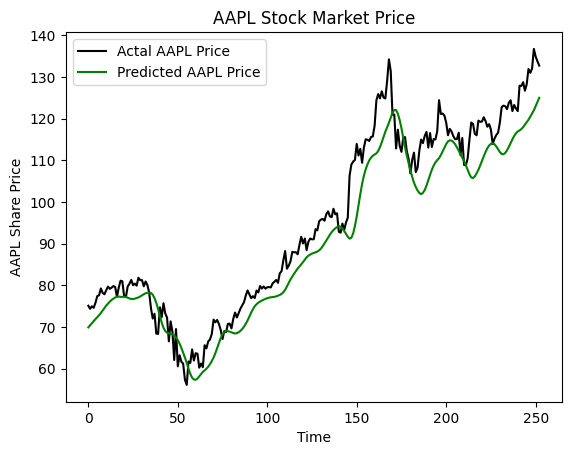

In [12]:
# plot the test predictions #
plt.plot(actual_prices, color="black", label=f"Actal {comp} Price")
plt.plot(prediction_prices, color="green", label=f"Predicted {comp} Price")
plt.title(f"{comp} Stock Market Price")
plt.xlabel("Time")
plt.ylabel(f"{comp} Share Price")
plt.legend()
plt.show()


In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices, prediction_prices))

# Calculate MAE
mae = mean_absolute_error(actual_prices, prediction_prices)

# Calculate MAPE
mape = (mae / np.mean(actual_prices)) * 100

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

RMSE: 6.680763034527168
MAE: 5.541260851230546
MAPE: 5.811673675691113


In [14]:
# predict the next day #
real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

print(scaler.inverse_transform(real_data[-1]))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"nxt prediction : {prediction}")

[[114.97000122]
 [116.97000122]
 [124.40000153]
 [121.09999847]
 [121.19000244]
 [120.70999908]
 [119.01999664]
 [115.98000336]
 [117.51000214]
 [116.87000275]
 [115.75      ]
 [115.04000092]
 [115.05000305]
 [116.59999847]
 [111.19999695]
 [115.31999969]
 [108.86000061]
 [108.76999664]
 [110.44000244]
 [114.94999695]
 [119.02999878]
 [118.69000244]
 [116.31999969]
 [115.97000122]
 [119.48999786]
 [119.20999908]
 [119.26000214]
 [120.30000305]
 [119.38999939]
 [118.02999878]
 [118.63999939]
 [117.33999634]
 [113.84999847]
 [115.16999817]
 [116.02999878]
 [116.58999634]
 [119.05000305]
 [122.72000122]
 [123.08000183]
 [122.94000244]
 [122.25      ]
 [123.75      ]
 [124.37999725]
 [121.77999878]
 [123.23999786]
 [122.41000366]
 [121.77999878]
 [127.87999725]
 [127.80999756]
 [128.69999695]
 [126.66000366]
 [128.22999573]
 [131.88000488]
 [130.96000671]
 [131.97000122]
 [136.69000244]
 [134.86999512]
 [133.72000122]
 [132.69000244]]
1/1 [==============================] - 2s 2s/step
nxt p